# NSI–BRAILS Integration Example
Written by bacetiner, fmk, yisangriB

## Install BRAILS++ and Plotly

In [ ]:
!pip install git+https://github.com/NHERI-SimCenter/BrailsPlusPlus
!pip install plotly

## Import Required Packages

In [1]:
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from brails import Importer

## Create a RegionBoundary for Area of Interest

In [2]:
LOCATION = "Tiburon, CA"

# Create an Importer instance:
importer = Importer()

# Create a region boundary:
region_boundary_class = importer.get_class('RegionBoundary')
region_boundary_object = region_boundary_class({'type': 'locationName',
                                                'data': LOCATION})

## Create an NSI Inventory by Downloading Raw Data

In [3]:
nsi_class = importer.get_class('NSI_Parser')
nsi = nsi_class()
nsi_inventory = nsi.get_raw_data_given_boundary(region_boundary_object, 'ft')

print('Total number of assets detected using NSI is '
      f'{len(nsi_inventory.inventory)}')


Searching for Tiburon, CA...
Found Tiburon, Marin County, California, 94920, United States

Getting National Structure Inventory (NSI) building data for the entered location input...
Found a total of 3597 building points in NSI that are within the entered region of interest
Total number of assets detected using NSI is 3597


## Create an Inventory By Merging Footprint Data with NSI Raw Data

In [4]:
# Scrape the building inventory from OSM:
scraper_class = importer.get_class('OSM_FootprintScraper')
scraper = scraper_class({'length': 'ft'})
scraper_inventory = scraper.get_footprints(region_boundary_object)

# Merge these footprints with the NSI raw data previously downlaoded:
nsi_processed_data = nsi.get_filtered_data_given_inventory(scraper_inventory)


Searching for Tiburon, CA...
Found Tiburon, Marin County, California, 94920, United States

Found a total of 3249 building footprints in Tiburon

Getting National Structure Inventory (NSI) building data for the entered location input...
Found a total of 2788 building points in NSI that match the footprint data.


## Plot NSI Raw Data

In [5]:
# Table for the raw data:
inventory_df, geom_df, nbldg = nsi_inventory.get_dataframe()
inventory_df.replace('', np.nan, inplace=True) # for visualization
inventory_df.replace('NA', np.nan, inplace=True) # for visualization

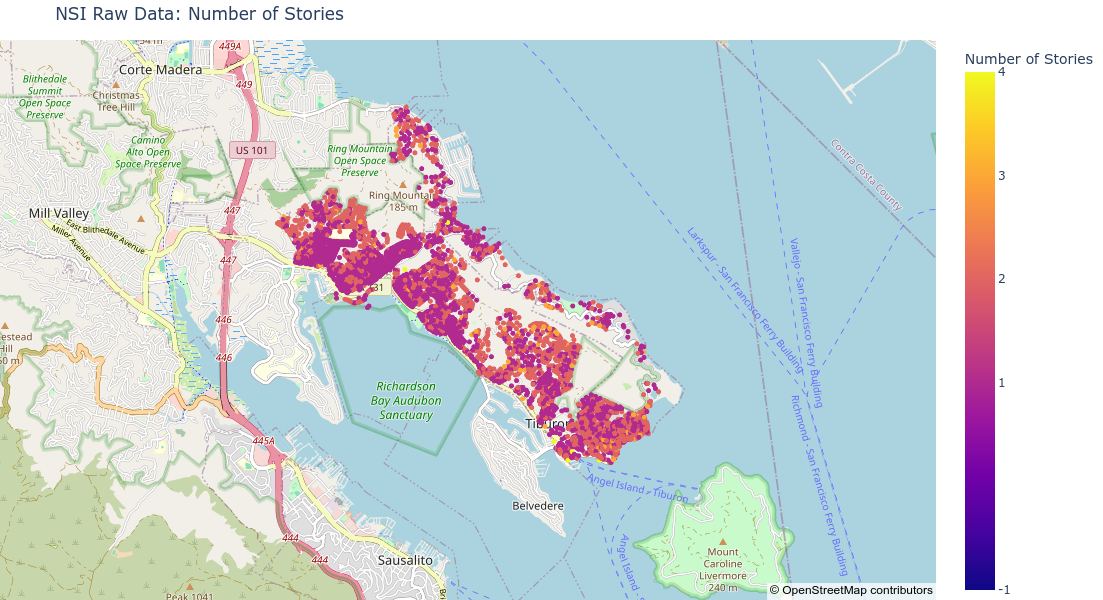

In [6]:
fig = px.scatter_mapbox(geom_df, lat="Lat", lon="Lon", color=(inventory_df["num_story"].astype(float)),range_color=[-1,4],zoom=12, mapbox_style='open-street-map',width=800, height=600,title='NSI Raw Data: Number of Stories')
fig.update_geos(projection_type="mercator", showland=True, landcolor="white", showocean=True, oceancolor="lightblue", coastlinecolor="gray")
fig.update_layout(margin={"r":0, "t":40, "l":0, "b":0}, hovermode="closest", coloraxis_colorbar=dict(title="Number of Stories", tickvals=[-1, 1, 2, 3, 4], ticktext=["-1", "1", "2", "3", "4"]))
fig.show()

## Merge NSI Data with the Obtained Footprint Geometries

In [7]:
# Foootprints for the filtered data:
inventory_footprints, _ = nsi_processed_data.get_coordinates()

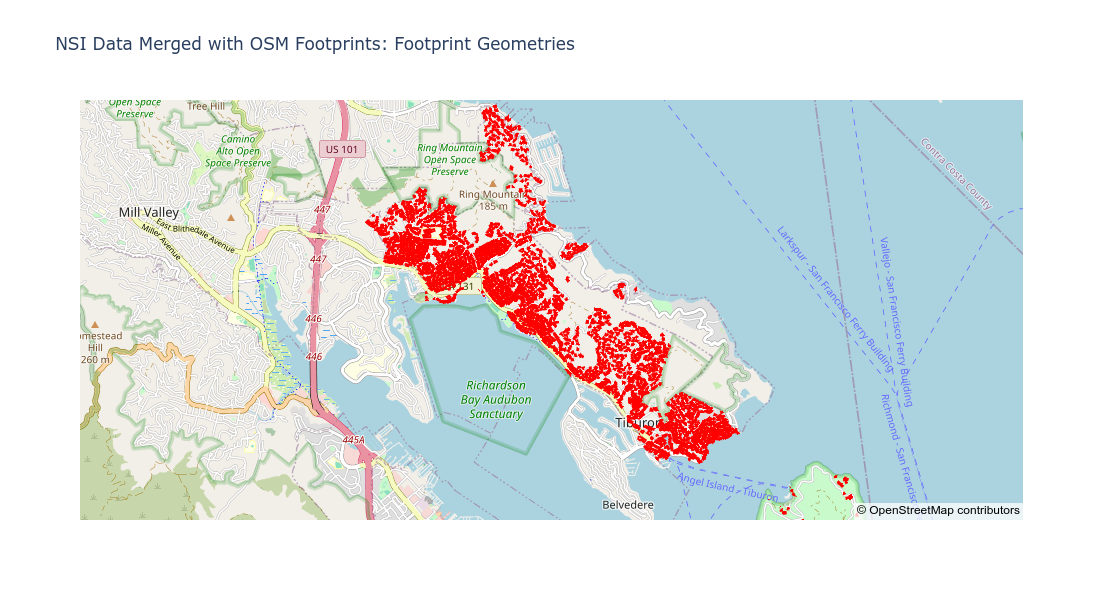

In [8]:
all_coords = [coord for path in inventory_footprints for coord in path]
center_lat = sum(point[1] for point in all_coords) / len(all_coords)
center_lon = sum(point[0] for point in all_coords) / len(all_coords)

# Prepare data for a single trace with breaks between paths
lats = []; lons = []
for path in inventory_footprints:
    for point in path:
        lats.append(point[1])
        lons.append(point[0])
    # Add None to break lines between paths
    lats.append(None)
    lons.append(None)

fig = go.Figure(go.Scattermapbox(lat=lats, lon=lons, mode="lines", marker=go.scattermapbox.Marker(size=8, color="blue"), line=dict(color="red", width=2)))
fig.update_layout(mapbox=dict(style="open-street-map",center=dict(lat=center_lat, lon=center_lon),zoom=12),width=800, height=600, title='NSI Data Merged with OSM Footprints: Footprint Geometries',showlegend=False)
fig.update_geos(projection_type="mercator", showland=True, landcolor="white", showocean=True, oceancolor="lightblue", coastlinecolor="gray")
fig.show()